Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random
import matplotlib.pyplot as plt
import math
import matplotlib.gridspec as gridspec


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
folder = 'notMNIST_large'
dirs = [folder + '/' + d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

image_files = []

for directory in dirs:
    dir_image_files = os.listdir(directory)
    dir_image_files = [directory + '/'+ s for s in dir_image_files]
    
    rand_images = random.sample(dir_image_files, 2)
    image_files = image_files + rand_images
 
for image in image_files:
    im = Image(filename=image)
    display(im)



# Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756304
Standard deviation: 0.454491
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Full dataset tensor: (52912, 28, 28)
Mean: -0.142258
Standard deviation: 0.439807
Pickling notMNIST_large/D.pickle.
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : canno

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

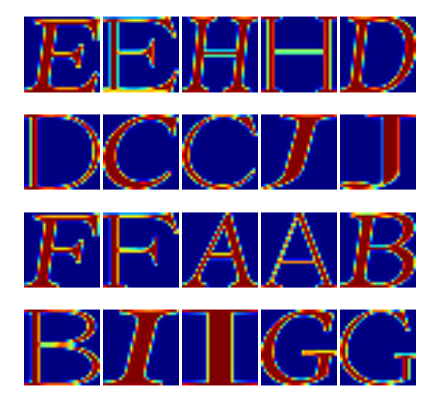

In [6]:
folder = 'notMNIST_large'
pkl_data_files = [folder + '/' + d for d in os.listdir(folder) if "pickle" in d]

def calc_index(ix):
    row = math.ceil(ix/5.0)-1
    col = ix - (row*5) - 1
    if(ix == 0):
        return 0, 0
    return int(row), int(col)

image_files = []

fig, ax = plt.subplots(4,5, sharex='col',sharey='row', figsize=(7,7), gridspec_kw={'wspace':0.055, 'hspace':0.0005})
file_num = 1

#loop through each of the pickle files for each letter and display the first two images
for pkl_file in pkl_data_files:
    pkl_file = open(pkl_file, 'rb')
    pkl_data = pickle.load(pkl_file)
    
    row, col = calc_index(file_num)
    row2, col2 = calc_index((file_num+1))
    
    ax[row][col].imshow(pkl_data[0,:,:])
    ax[row2][col2].imshow(pkl_data[1,:,:])
    ax[row][col].axis('off')
    ax[row2][col2].axis('off')
    file_num = file_num + 2

plt.show()



---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
folder = 'notMNIST_large'
pkl_data_files = [folder + '/' + d for d in os.listdir(folder) if "pickle" in d]

image_files = []

#loop through each of the pickle files and count the number of images
for pkl_file_path in pkl_data_files:
    pkl_file = open(pkl_file_path, 'rb')
    pkl_data = pickle.load(pkl_file)
    print(pkl_file_path.replace("notMNIST_large/","").replace(".pickle",":"), int(pkl_data.shape[0]))


E: 52912
H: 52912
D: 52911
C: 52912
J: 52911
F: 52912
A: 52909
B: 52911
I: 52912
G: 52912


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [11]:
folder = 'notMNIST_large'
pkl_data_files = [folder + '/' + d for d in os.listdir(folder) if "pickle" in d]

letter_lookup = []
#removed original
for label, pickle_file in enumerate(train_datasets):
#for label, pickle_file in enumerate(pkl_data_files):
    letter_lookup.append(pickle_file.replace("notMNIST_large/","").replace(".pickle",""))
    print(label, " ", pickle_file)
    
def calc_index(ix):
    row = math.ceil(ix/5.0)-1
    col = ix - (row*5) - 1
    if(ix == 0):
        return 0, 0
    return int(row), int(col)

def display20images(title, dataset, labels, randomize = None):
    fig, ax = plt.subplots(4,5, sharex='col',sharey='row', figsize=(7,7), gridspec_kw={'wspace':0.055, 'hspace':0.1})
    fig.suptitle(title, fontsize=16)
    plot_num = 1

    #select 20 random images and display them
    lst = []
    if randomize is not None:
        lst = randomize
    else:
        lst = [random.randint(0, int(dataset.shape[0])) for x in range(20)]

    for i in lst:
        cur_image = dataset[i,:,:]
        cur_label = labels[i]

        row, col = calc_index(plot_num)

        ax[row][col].imshow(cur_image)
        ax[row][col].axis('off')
        ax[row][col].set_title(letter_lookup[cur_label])
        plot_num = plot_num + 1

    plt.show()

0   notMNIST_large/A.pickle
1   notMNIST_large/B.pickle
2   notMNIST_large/C.pickle
3   notMNIST_large/D.pickle
4   notMNIST_large/E.pickle
5   notMNIST_large/F.pickle
6   notMNIST_large/G.pickle
7   notMNIST_large/H.pickle
8   notMNIST_large/I.pickle
9   notMNIST_large/J.pickle


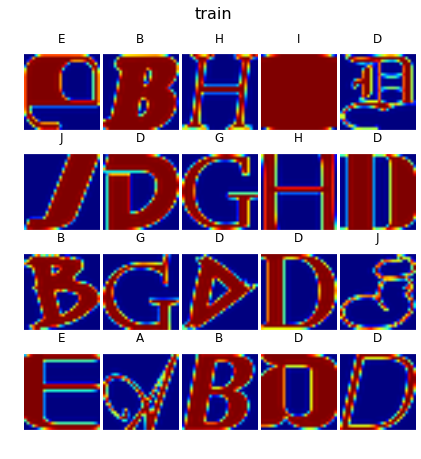

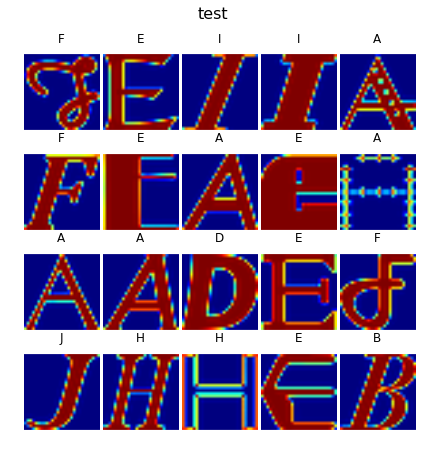

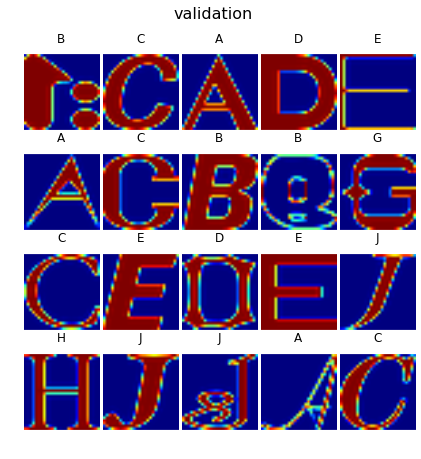

In [12]:
display20images('train',train_dataset, train_labels)
display20images('test',test_dataset, test_labels)
display20images('validation',valid_dataset, valid_labels) 

Finally, let's save the data for later reuse:

In [15]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [17]:
def load_pickled_data():
    all_data_pkl_path = open('notMNIST.pickle', 'rb')
    all_data = pickle.load(all_data_pkl_path)

    train_data = all_data['train_dataset']
    test_data = all_data['test_dataset']
    valid_data = all_data['valid_dataset']
    
    train_labels = all_data['train_labels']
    test_labels = all_data['test_labels']
    valid_labels = all_data['valid_labels']
    
    combined_data = np.vstack((train_data, test_data))
    combined_data = np.vstack((combined_data, valid_data))

    print("train labels: ", train_labels.shape)
    print("test labels: ", test_labels.shape)
    print("valid labels: ", valid_labels.shape)
    
    combined_labels = np.hstack((train_labels, test_labels))
    combined_labels = np.hstack((combined_labels, valid_labels))
    
    return combined_data, combined_labels

all_data, all_labels = load_pickled_data()

print("")
print("total labels: ", all_labels.shape)
print("total data: ", all_data.shape)


train labels:  (200000,)
test labels:  (10000,)
valid labels:  (10000,)

total labels:  (220000,)
total data:  (220000, 28, 28)


Searching for duplicates and removing them

total data:  (220000, 28, 28)
total labels:  (220000,) 

total rows searched for dups:  220000
number of duplicates found:  15068 

deduped data:  (204932, 28, 28)
deduped labels:  204932 


Verifying all duplicates are still removed after shuffle and split
total rows searched for dups:  204932
number of duplicates found:  0 

valid dataset size:  (10000, 28, 28)  labels:  10000
test dataset size:  (10000, 28, 28)  labels:  10000
train dataset size:  (184932, 28, 28)  labels:  184932 


Verifying labels are still valid after suffle and split


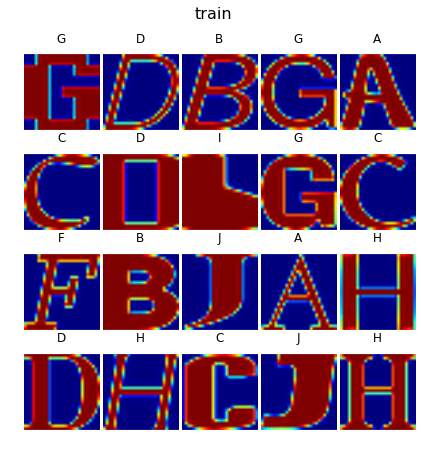

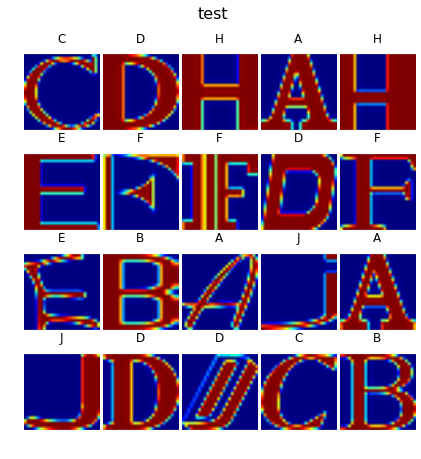

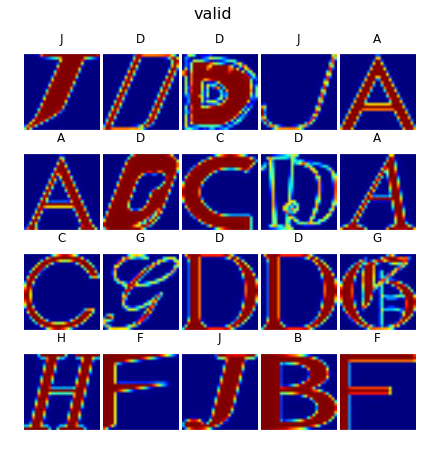

In [18]:
import hashlib

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

def generateHashTableFromDataset(dataset):
    data_size = int(dataset.shape[0])
    dups = []
    dup_indexes = []
    hash_t = {}    
    for i in range(0, data_size):
        cur_hash = hashlib.md5(dataset[i,:,:]).hexdigest()
        
        #the first occurence will not be added to the dup_indexes that way we keep one instance and remove the others
        if cur_hash in hash_t:
            hash_t[cur_hash] += 1
            dups.append([i, cur_hash])
            dup_indexes.append(i)
        else:
            hash_t[cur_hash] = 1
                  
    return hash_t, dups, dup_indexes

hash_t, dups, dup_indexes = generateHashTableFromDataset(all_data)

deduped_data = np.delete(all_data, dup_indexes, axis=0)
deduped_labels = np.delete(all_labels, dup_indexes, axis=0)

print("Searching for duplicates and removing them\n")
print("total data: ", all_data.shape)
print("total labels: ", all_labels.shape,"\n")

print("total rows searched for dups: ", sum(hash_t.values()))
print("number of duplicates found: ", len(dups),"\n")

print("deduped data: ", deduped_data.shape)
print("deduped labels: ", len(deduped_labels),"\n")

valid_size = 10000
test_size = 10000

deduped_data_shuffled, deduped_labels_shuffled = randomize(deduped_data, deduped_labels)
valid_data = deduped_data_shuffled[0:valid_size,:,:]
test_data = deduped_data_shuffled[valid_size:(valid_size+test_size),:,:]
train_data = deduped_data_shuffled[(valid_size+test_size):int(deduped_data.shape[0]),:,:]

valid_labels = deduped_labels_shuffled[0:valid_size]
test_labels = deduped_labels_shuffled[valid_size:(valid_size+test_size)]
train_labels = deduped_labels_shuffled[(valid_size+test_size):int(deduped_data.shape[0])]


#verifying still no dups after shuffle and split
combined_data = np.vstack((train_data, test_data))
combined_data = np.vstack((combined_data, valid_data))
hash_t, dups, dup_indexes = generateHashTableFromDataset(combined_data)

print("\nVerifying all duplicates are still removed after shuffle and split")
print("total rows searched for dups: ", sum(hash_t.values()))
print("number of duplicates found: ", len(dups),"\n")

print("valid dataset size: ", valid_data.shape, " labels: ", len(valid_labels))
print("test dataset size: ", test_data.shape, " labels: ", len(test_labels))
print("train dataset size: ", train_data.shape, " labels: ", len(train_labels), "\n")

#requires running code far above
#testing to make sure labels are still valid
print("\nVerifying labels are still valid after suffle and split")
display20images('train',train_data, train_labels)
display20images('test',test_data, test_labels)
display20images('valid',valid_data, valid_labels)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

Confusion Matrix


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


[[790  22  12  25  13  30  23  39  37  34]
 [ 35 751  17  56  33  28  30  23  29  15]
 [ 19  21 802  11  52  26  46  15  27  16]
 [ 27  21  18 817  13  24  19  27  32  27]
 [ 25  32  71  21 725  44  31  21  46  18]
 [ 27   9  19  17  27 783  12  17  29  29]
 [ 27  22  53  23  18  31 771  16  27  46]
 [ 50  23  10  21  17  14  17 754  31  17]
 [ 24  12  19  19  29  43  25  25 659  46]
 [ 25   8  10  24  16  23  24  15  45 816]]

overall accuracy:  0.7668


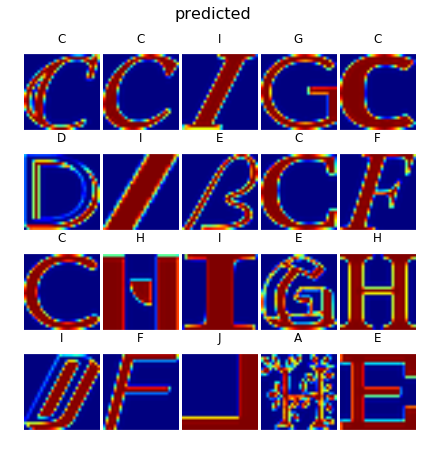

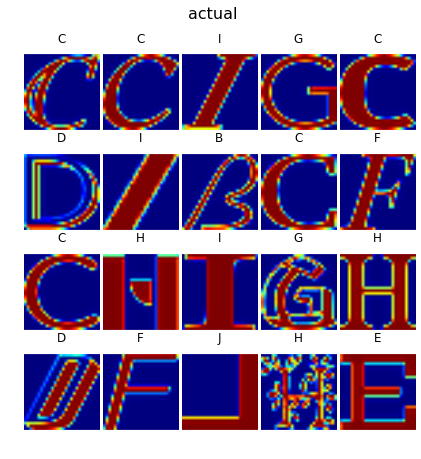

61.6097071171


In [19]:
from sklearn import metrics
import time

start = time.time()
train_size = 5000
img_size = 28
test_size = 10000

X = train_data[0:train_size,:,:]
Xreshape = X.reshape(train_size,img_size*img_size)
Y = train_labels[0:train_size]

test_dataR = test_data[0:test_size, :, :]
test_labelsR = test_labels[0:test_size]
testR = test_dataR.reshape(int(test_dataR.shape[0]),img_size*img_size)

logreg = LogisticRegression(solver='sag', max_iter = 1000)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(Xreshape, Y)

predicted = logreg.predict(testR)
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labelsR, predicted))
print("\noverall accuracy: ", metrics.accuracy_score(test_labelsR, predicted))

lst = [random.randint(0, int(test_dataR.shape[0])) for x in range(20)]

display20images('predicted',test_dataR, predicted, randomize=lst)
display20images('actual',test_dataR, test_labelsR, randomize=lst)

end = time.time()
print(end - start)
#82.42 accuracy with 100K 2,200 seconds
#83.46 accuracy with 184K 4,177 seconds
#79.8  accuracy with 19K training, 5K testing
#69.5% accuracy with 5K or 10K